<a href="https://colab.research.google.com/github/RibhuAgarwal/batteryRUL/blob/main/DBMS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Path to dataset files: /root/.cache/kagglehub/datasets/ignaciovinuales/battery-remaining-useful-life-rul/versions/3
   Cycle_Index  Discharge Time (s)  Decrement 3.6-3.4V (s)  \
0          1.0             2595.30             1151.488500   
1          2.0             7408.64             1172.512500   
2          3.0             7393.76             1112.992000   
3          4.0             7385.50             1080.320667   
4          6.0            65022.75            29813.487000   

   Max. Voltage Dischar. (V)  Min. Voltage Charg. (V)  Time at 4.15V (s)  \
0                      3.670                    3.211           5460.001   
1                      4.246                    3.220           5508.992   
2                      4.249                    3.224           5508.993   
3                      4.250                    3.225           5502.016   
4                      4.290                    3.398           5480.992   

   Time constant current (s)  Charging time (s)   RUL 

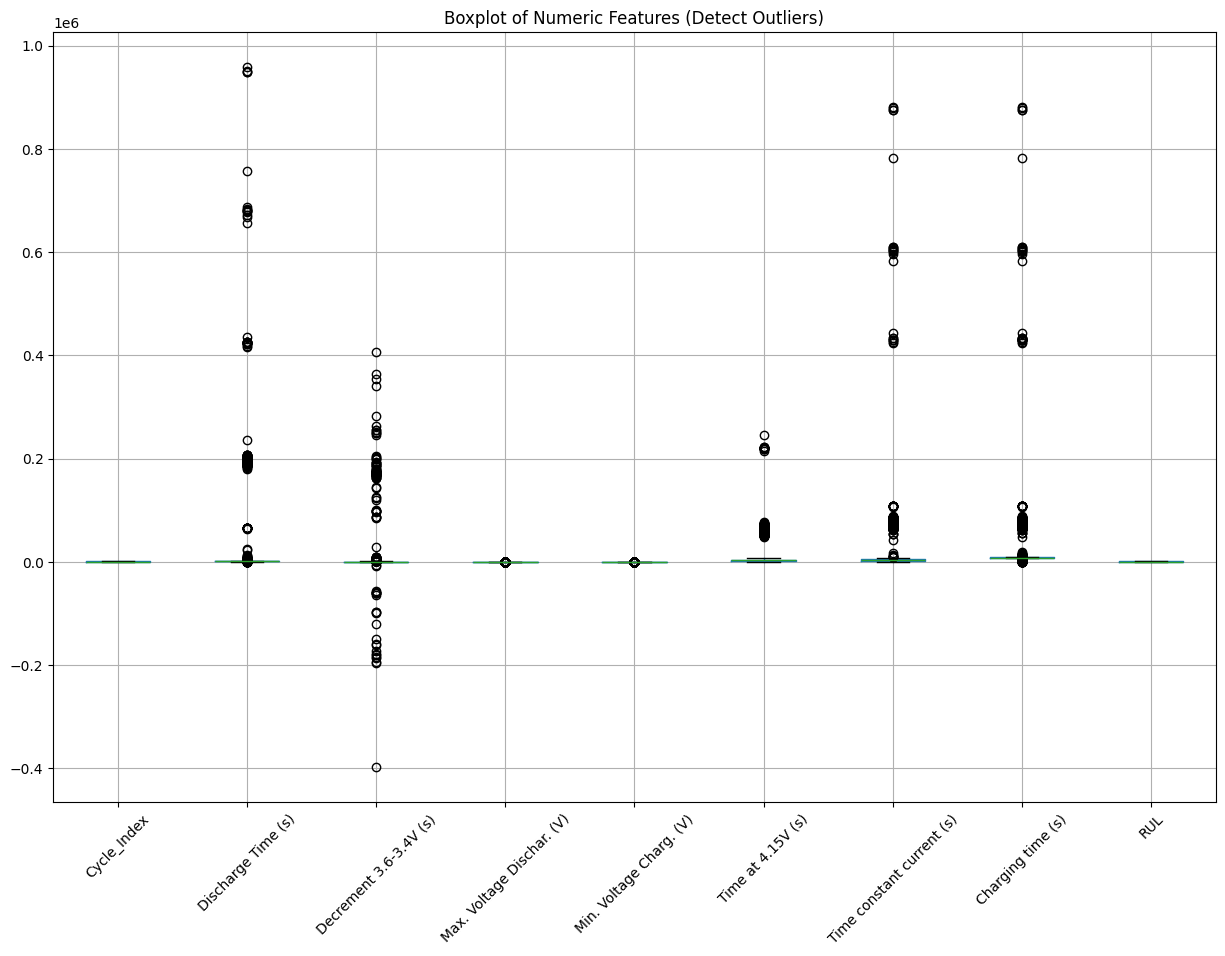

Missing values after handling negatives:
 Cycle_Index                   0
Discharge Time (s)            0
Decrement 3.6-3.4V (s)       24
Max. Voltage Dischar. (V)     0
Min. Voltage Charg. (V)       0
Time at 4.15V (s)             9
Time constant current (s)     0
Charging time (s)             0
RUL                           0
dtype: int64
Original size: 15064, Cleaned size: 14425


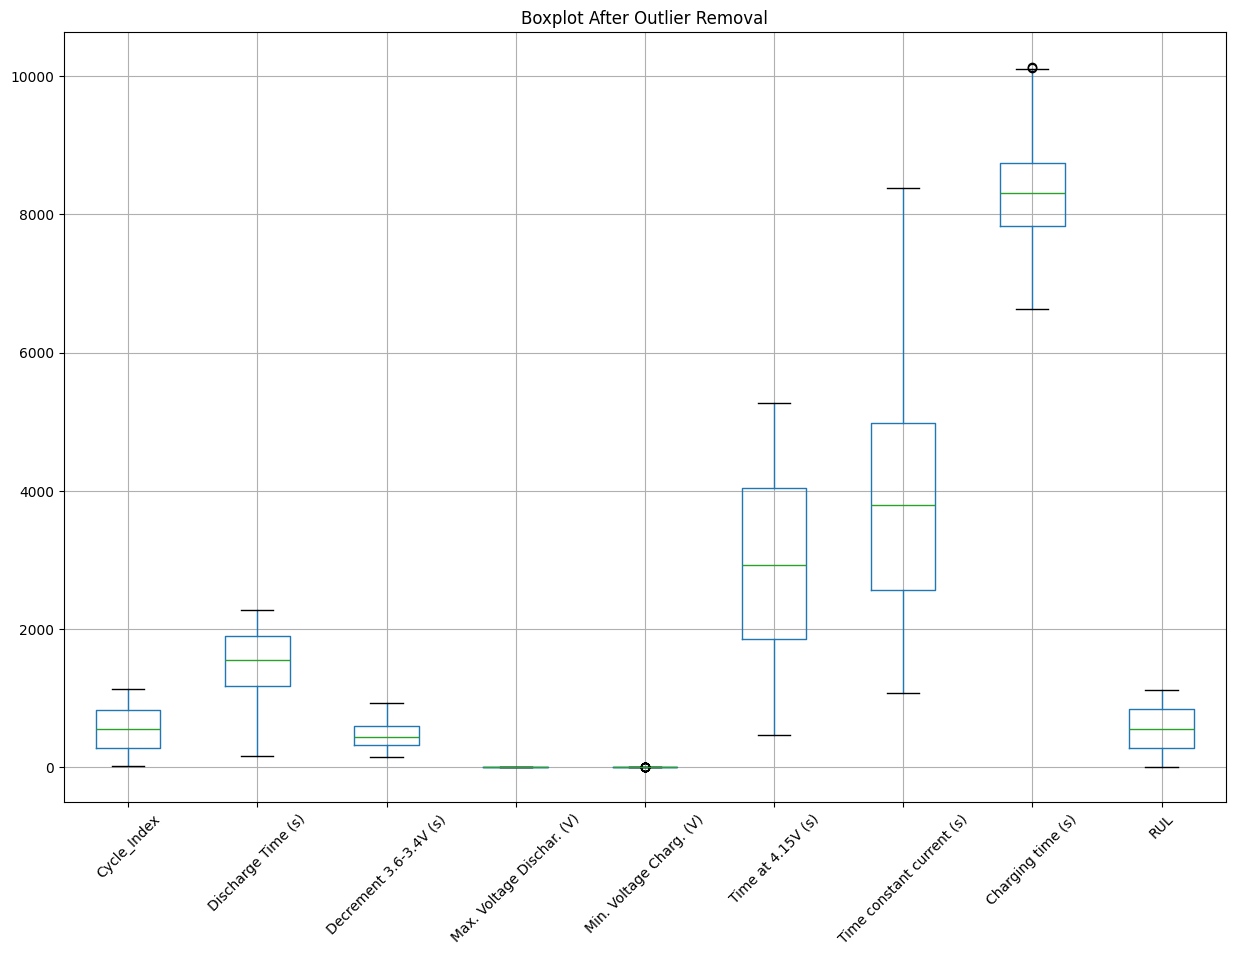


🔍 Random Forest Evaluation Metrics:
• MAE   (Mean Absolute Error)        : 8.20
• RMSE  (Root Mean Squared Error)    : 15.67
• R²    (R-squared Score)            : 1.00
• MAPE  (Mean Absolute % Error)      : 10.90%
• SMAPE (Symmetric Mean Absolute %)  : 4.30%


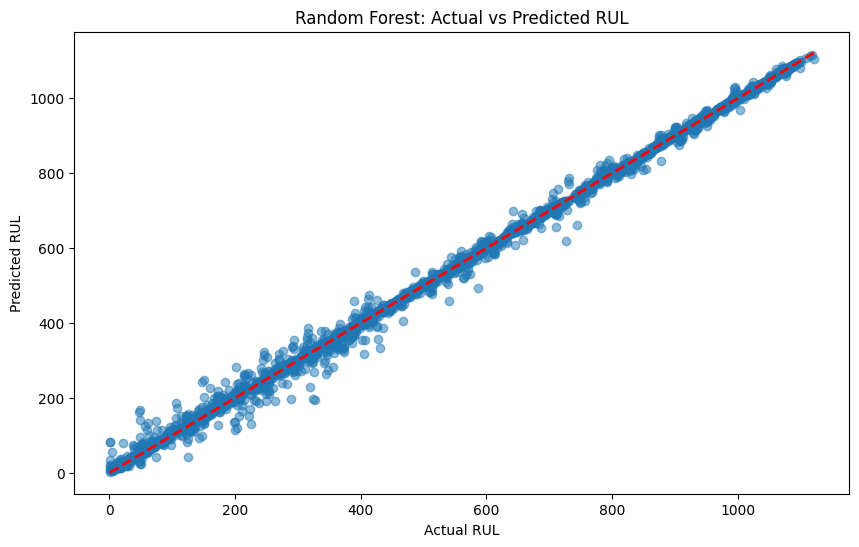


🔍 XGBoost Evaluation Metrics:
• MAE   (Mean Absolute Error)        : 15.82
• RMSE  (Root Mean Squared Error)    : 23.39
• R²    (R-squared Score)            : 0.99
• MAPE  (Mean Absolute % Error)      : 16.77%
• SMAPE (Symmetric Mean Absolute %)  : 7.52%

🔍 Random Forest + Feature Engineering Evaluation Metrics:
• MAE   (Mean Absolute Error)        : 8.51
• RMSE  (Root Mean Squared Error)    : 16.54
• R²    (R-squared Score)            : 1.00
• MAPE  (Mean Absolute % Error)      : 11.03%
• SMAPE (Symmetric Mean Absolute %)  : 4.39%


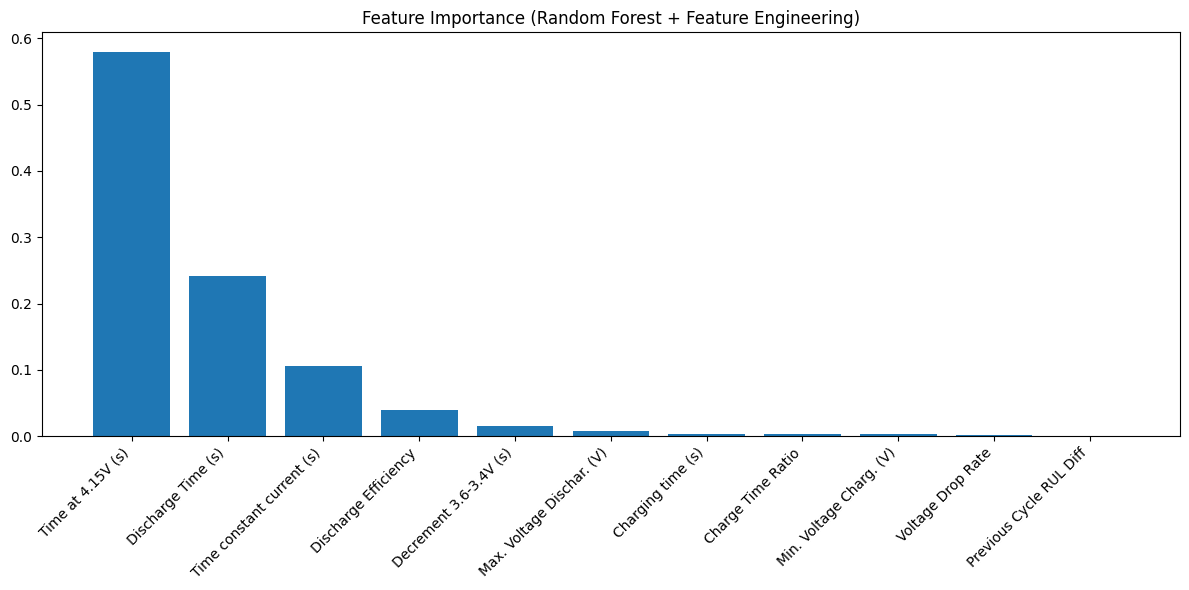


🔍 Random Forest (Selected Features) Evaluation Metrics:
• MAE   (Mean Absolute Error)        : 28.74
• RMSE  (Root Mean Squared Error)    : 42.18
• R²    (R-squared Score)            : 0.98
• MAPE  (Mean Absolute % Error)      : 22.20%
• SMAPE (Symmetric Mean Absolute %)  : 11.84%


{'MAE': 28.73719113366895,
 'RMSE': 42.180578441884556,
 'R2': 0.982398845952199,
 'MAPE': np.float64(22.196548965119455),
 'SMAPE': np.float64(11.836857991511984)}

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ignaciovinuales/battery-remaining-useful-life-rul")
df = pd.read_csv(f"{path}/Battery_RUL.csv")

print("Path to dataset files:", path)

# Initial inspection
print(df.head())
df.info()
print(df.describe())

# Boxplot to visualize outliers
plt.figure(figsize=(15, 10))
df.boxplot(rot=45)
plt.title("Boxplot of Numeric Features (Detect Outliers)")
plt.show()

# Replace negative values with NaN
df[df < 0] = np.nan
print("Missing values after handling negatives:\n", df.isnull().sum())

# Function to remove outliers
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

# Clean outliers (exclude target and identifier)
df_cleaned = remove_outliers(df, df.columns.difference(['Cycle_Index', 'RUL']))

# Check data size post-cleaning
print(f"Original size: {len(df)}, Cleaned size: {len(df_cleaned)}")

# Boxplot after cleaning
plt.figure(figsize=(15, 10))
df_cleaned.boxplot(rot=45)
plt.title("Boxplot After Outlier Removal")
plt.show()

# Normalize features
features_to_normalize = [
    "Discharge Time (s)", "Decrement 3.6-3.4V (s)", "Max. Voltage Dischar. (V)",
    "Min. Voltage Charg. (V)", "Time at 4.15V (s)", "Time constant current (s)",
    "Charging time (s)"
]
scaler = MinMaxScaler()
df_cleaned[features_to_normalize] = scaler.fit_transform(df_cleaned[features_to_normalize])

# Feature & Target selection
X = df_cleaned.drop(columns=["RUL", "Cycle_Index"])
y = df_cleaned["RUL"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest
def evaluate(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)

    # MAPE and SMAPE
    mape = np.mean(np.abs((y_true - y_pred) / np.clip(y_true, 1e-8, None))) * 100
    smape = 100 * np.mean(
        2.0 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8)
    )

    print(f"\n🔍 {model_name} Evaluation Metrics:")
    print(f"• MAE   (Mean Absolute Error)        : {mae:.2f}")
    print(f"• RMSE  (Root Mean Squared Error)    : {rmse:.2f}")
    print(f"• R²    (R-squared Score)            : {r2:.2f}")
    print(f"• MAPE  (Mean Absolute % Error)      : {mape:.2f}%")
    print(f"• SMAPE (Symmetric Mean Absolute %)  : {smape:.2f}%")

    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE": mape, "SMAPE": smape}


evaluate(y_test, y_pred_rf, "Random Forest")

# Plot prediction results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Random Forest: Actual vs Predicted RUL")
plt.show()

# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1,
                             objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate(y_test, y_pred_xgb, "XGBoost")

# Feature Engineering
df_cleaned["Voltage Drop Rate"] = (
    df_cleaned["Max. Voltage Dischar. (V)"] - df_cleaned["Min. Voltage Charg. (V)"]
) / df_cleaned["Discharge Time (s)"]
df_cleaned["Charge Time Ratio"] = df_cleaned["Charging time (s)"] / df_cleaned["Discharge Time (s)"]
df_cleaned["Discharge Efficiency"] = df_cleaned["Time constant current (s)"] / df_cleaned["Discharge Time (s)"]
df_cleaned["Previous Cycle RUL Diff"] = df_cleaned["RUL"].diff().fillna(0)

# Handle NaN/inf
df_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned.fillna(df_cleaned.median(), inplace=True)

# Retrain with engineered features
X_eng = df_cleaned.drop(columns=["Cycle_Index", "RUL", "Cycle Normalized RUL"], errors="ignore")
y_eng = df_cleaned["RUL"]
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.2, random_state=42)

rf_eng = RandomForestRegressor(n_estimators=100, random_state=42)
rf_eng.fit(X_train_eng, y_train_eng)
y_pred_eng = rf_eng.predict(X_test_eng)
evaluate(y_test_eng, y_pred_eng, "Random Forest + Feature Engineering")

# Feature importance
importances = rf_eng.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_eng.columns

plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=45, ha="right")
plt.title("Feature Importance (Random Forest + Feature Engineering)")
plt.tight_layout()
plt.show()

# Minimal Feature Set
selected_features = ["Time at 4.15V (s)", "Discharge Time (s)", "Time constant current (s)", "Discharge Efficiency"]
X_sel = df_cleaned[selected_features]
y_sel = df_cleaned["RUL"]

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_sel, y_sel, test_size=0.2, random_state=42)
rf_sel = RandomForestRegressor(n_estimators=100, random_state=42)
rf_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = rf_sel.predict(X_test_sel)
evaluate(y_test_sel, y_pred_sel, "Random Forest (Selected Features)")
